In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

## Objetivos

Se pueden resumir de la siguiente manera:
* Evolucionar el modelo lineal que se había construido.
* Determinar en base a que _features_ se toman las predicciones.
* Elegir un modelo que tenga sentido con las variables que espera el negocio.
* Optimización del modelo.

In [7]:
# Cargamos los datos del modelo
DATA_PATH = 'files/feature_frame.csv'
ORDERS_PATH = 'files/orders.parquet'
df_base = pd.read_csv(DATA_PATH)

### Información básica

In [8]:
df_base.head(3)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [9]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

### Dividimos las columnas como hicimos en el EDA

In [10]:
target  = 'outcome'
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
feature_cols = [_ for _ in df_base.columns if _ not in [target] + info_cols]
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular'] 
categ_cols = ['product_type', 'vendor']
numeric_cols = [col for col in feature_cols if col not in binary_cols + categ_cols]
train_cols = numeric_cols + binary_cols

In [11]:
train_cols

['user_order_seq',
 'normalised_price',
 'discount_pct',
 'global_popularity',
 'count_adults',
 'count_children',
 'count_babies',
 'count_pets',
 'people_ex_baby',
 'days_since_purchase_variant_id',
 'avg_days_to_buy_variant_id',
 'std_days_to_buy_variant_id',
 'days_since_purchase_product_type',
 'avg_days_to_buy_product_type',
 'std_days_to_buy_product_type',
 'ordered_before',
 'abandoned_before',
 'active_snoozed',
 'set_as_regular']

### Definición perímetro

In [12]:
def perim_modelo(df: pd.DataFrame, min_items: int = 5) -> pd.DataFrame:
    """
    Given a df that has columns id | order_id it generates a new dataframe which
    contains the orders that have more items than the argument min_items
    """
    assert {'variant_id', 'order_id'}.issubset(set(df.columns))
    order_counts = df.groupby('order_id').size().reset_index(name='item_count')
    order_counts_filtered = order_counts[order_counts['item_count'] >= min_items]
    df = df.merge(order_counts_filtered, on='order_id', how='inner')
    return df

def col_to_datetime(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    assert col_name in df.columns
    try:
        df[col_name] = pd.to_datetime(df[col_name])
    except:
        print(f"Could not change types at {df.head()}, with column {col_name}")
    return df


In [13]:

df_base = (
    df_base
        .pipe(perim_modelo, 5)
        .pipe(col_to_datetime, 'order_date')
        .pipe(col_to_datetime, 'created_at')
)



In [14]:
df_base.dtypes

variant_id                                   int64
product_type                                object
order_id                                     int64
user_id                                      int64
created_at                          datetime64[ns]
order_date                          datetime64[ns]
user_order_seq                               int64
outcome                                    float64
ordered_before                             float64
abandoned_before                           float64
active_snoozed                             float64
set_as_regular                             float64
normalised_price                           float64
discount_pct                               float64
vendor                                      object
global_popularity                          float64
count_adults                               float64
count_children                             float64
count_babies                               float64
count_pets                     

### Split temporal
Se opta por uno basado en el tiempo, por la condición de serie temporal del _dataset_.
_Split_ 70, 20, 10.

In [15]:
# Necesitamos la fecha de corte
ORDER_DATE = 'order_date'
df_base.sort_values(by=ORDER_DATE, inplace=True)
quantiles = df_base[ORDER_DATE].quantile([0.7, 0.9, 1.0])

# Extract the values for each quantile
quantile_0 = df_base[ORDER_DATE].min()
quantile_70 = quantiles.iloc[0]
quantile_90 = quantiles.iloc[1]
quantile_100 = quantiles.iloc[2]

print(f"Start: {quantile_0}\n q_70: {quantile_70}\n q_90: {quantile_90}\n End: {quantile_100}")

# Creamos divisiones en base al dato
df_train = df_base[df_base['order_date'] <= quantile_70]
df_val = df_base[(df_base['order_date'] > quantile_70) & (df_base['order_date'] <= quantile_90)]
df_test = df_base[df_base['order_date'] > quantile_90]

# Los datos quedan cortos, pero cubre al menos una semana, aunque no termina de ver un ciclo completo de dias de pago.

Start: 2020-10-05 00:00:00
 q_70: 2021-02-10 00:00:00
 q_90: 2021-02-25 00:00:00
 End: 2021-03-03 00:00:00


In [16]:
# generamos los splits
X_train = df_train.drop('outcome', axis=1)
y_train = df_train['outcome']

X_val = df_val.drop('outcome', axis=1)
y_val = df_val['outcome']

X_test = df_test.drop('outcome', axis=1)
y_test = df_test['outcome']


### Modelo base para poder comparar.

Utílizmaos el _baseline_ del módulo 3.

In [17]:
def generate_metrics(ax1, ax2, y_pred_prob: np.ndarray, y_test: np.ndarray, label: str) -> None:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # PR-curve
    ax1.plot(recall, precision, marker='.', label=f'{label}')
    ax1.set_title('Precision-Recall curve')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.legend(loc='best')

    # Roc-curve
    ax2.plot(fpr, tpr, marker='.', label=f'{label} (AUC = {roc_auc:.2f})')
    ax2.set_title('ROC curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc='best')

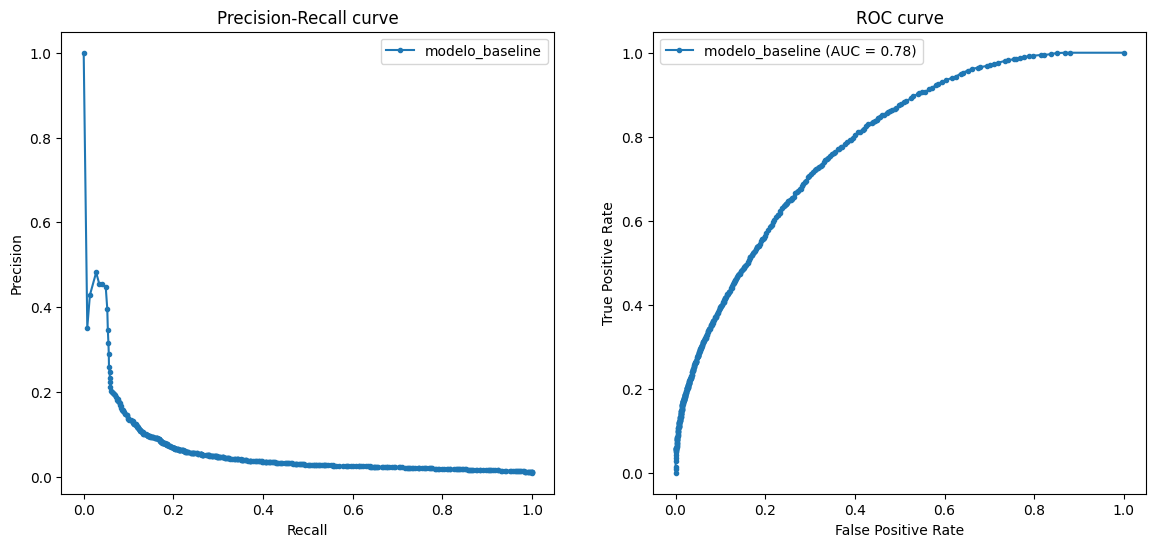

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
y_pred = X_test['global_popularity']
generate_metrics(ax1, ax2, y_pred, y_test, label=f'modelo_baseline')

### Random Forest

Con _Random Forest_ he intentado hacerlo funcionar con varias combinaciones. Y la verdad no he conseguido hacerlo funcionar bien con ninguna.
He probado a aumentar mucho el número de estimadores, jugar con el _alpha_ y el _max\_features_. Pero siempre me han quedado resultados que no han generalizado bien en test.

Cualquier _insight_ me vendría muy bien.

#### Probamos sin categóricas

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
modelo_rdf = RandomForestClassifier(n_estimators=200
                                    , criterion='gini'
                                    , max_depth=None
                                    , min_samples_split=2
                                    , min_samples_leaf=1
                                    , min_weight_fraction_leaf=0.0
                                    , max_features='sqrt'
                                    , max_leaf_nodes=None
                                    , min_impurity_decrease=0.0
                                    , bootstrap=True
                                    , oob_score=False
                                    , n_jobs=5
                                    , random_state=None
                                    , verbose=0
                                    , warm_start=False
                                    , class_weight=None
                                    , ccp_alpha=0.0
                                    , max_samples=None
                                    , monotonic_cst=None)

In [21]:
# 0.78

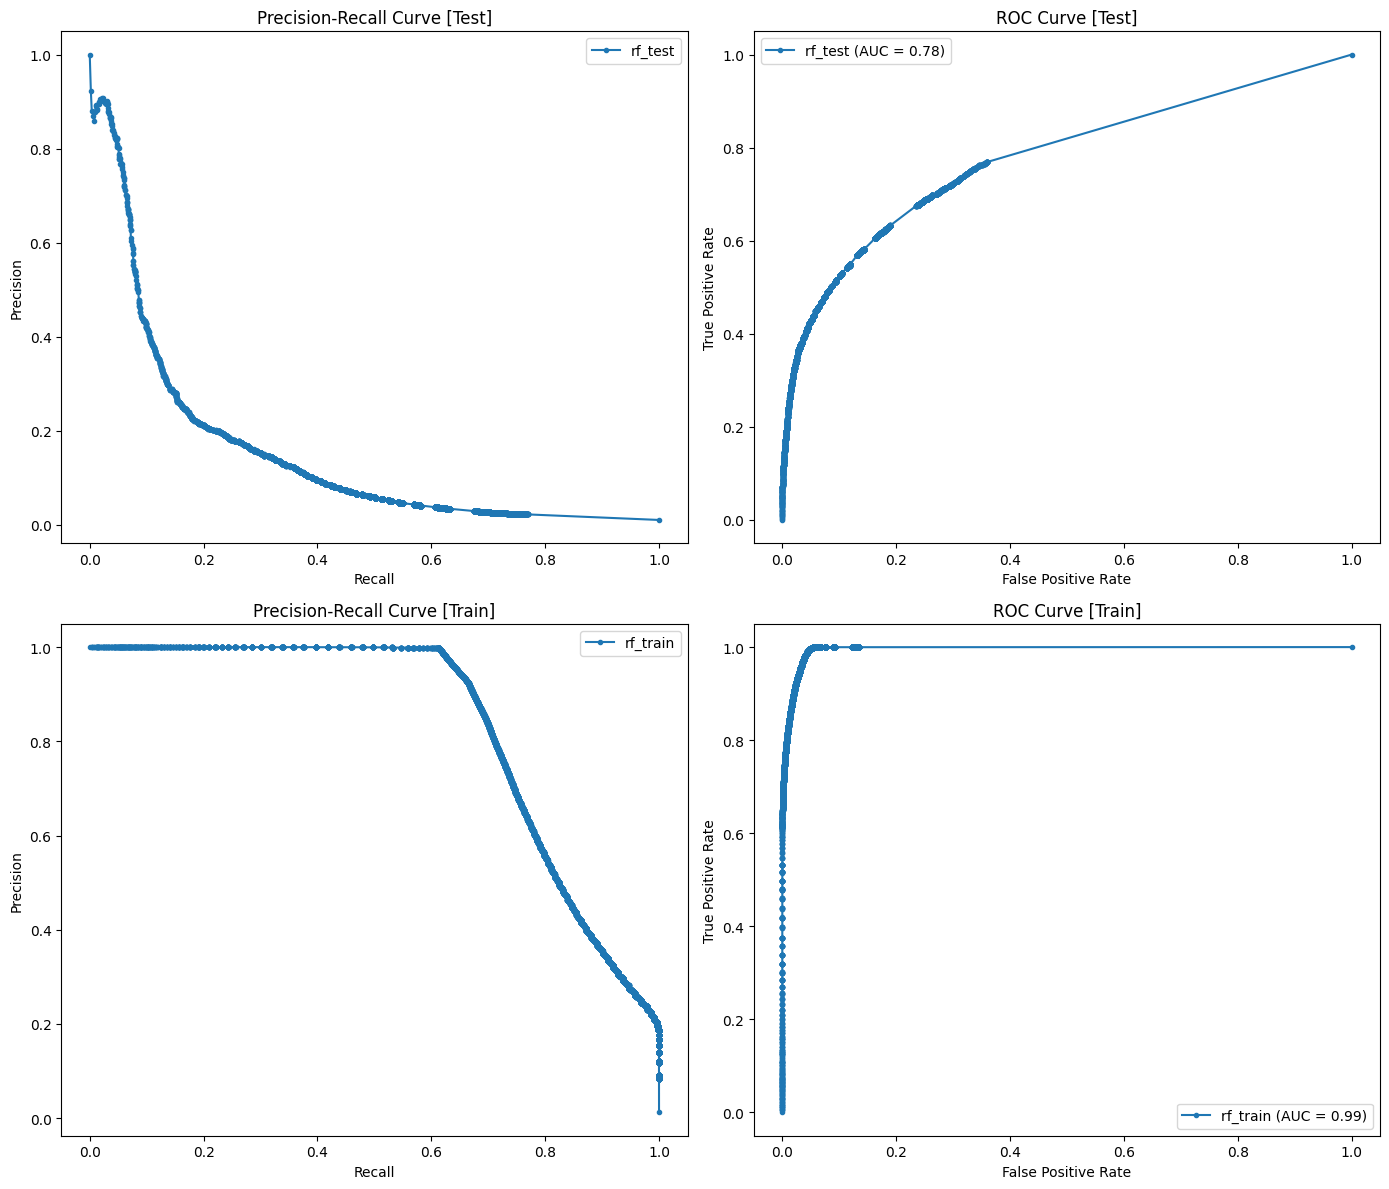

In [22]:
pipeline = Pipeline([
    ('random_forest_class', modelo_rdf)
    ])
pipeline.fit(X_train[train_cols], y_train)
# Sobre test
y_pred = pipeline.predict_proba(X_val[train_cols])[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
(ax_test_1, ax_test_2), (ax_train_1, ax_train_2) = axes
generate_metrics(ax_test_1, ax_test_2, y_pred, y_val, label=f'rf_test')
# Sobre train
y_pred_train = pipeline.predict_proba(X_train[train_cols])[:, 1]
generate_metrics(ax_train_1, ax_train_2, y_pred_train, y_train, label=f'rf_train')
ax_test_1.set_title('Precision-Recall Curve [Test]')
ax_test_2.set_title('ROC Curve [Test]')
ax_train_1.set_title('Precision-Recall Curve [Train]')
ax_train_2.set_title('ROC Curve [Train]')

plt.tight_layout()
plt.show()

#### Probamos con categóricas

#### Conclusiones

### GBT

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
gbt_model = GradientBoostingClassifier(loss='log_loss'
                          , learning_rate=0.1
                          , n_estimators=50
                          , max_depth=5)

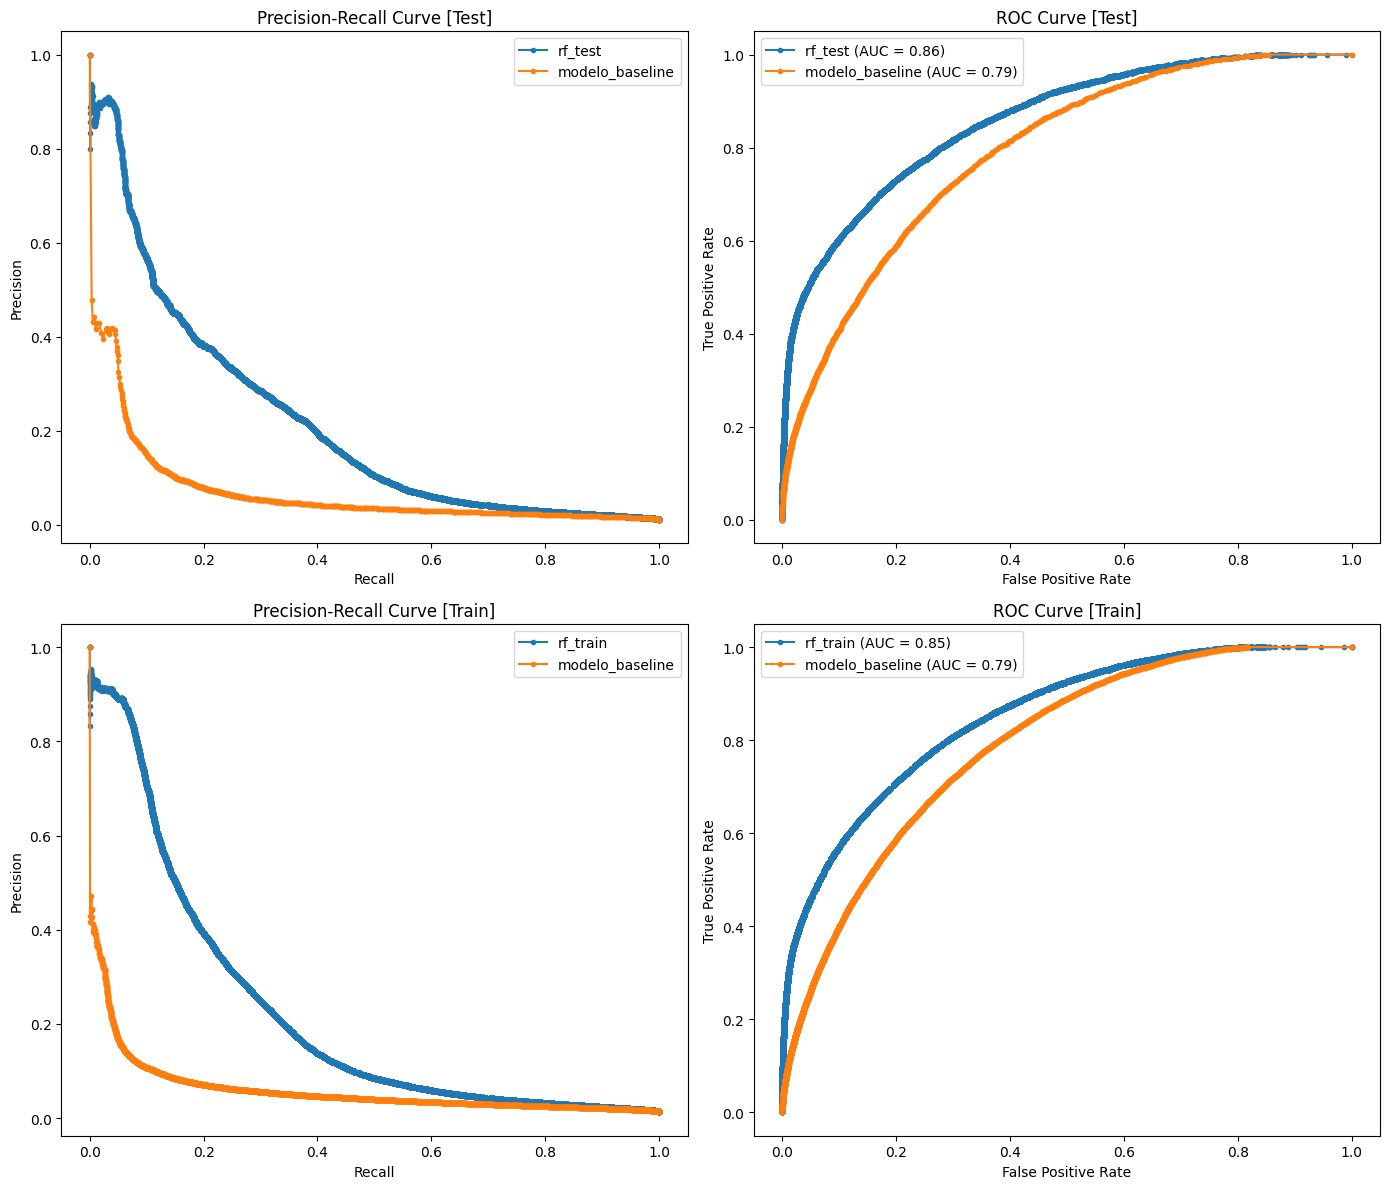

In [25]:
pipeline_gbt = Pipeline([
    ('gbt_model', gbt_model)
    ])
pipeline_gbt.fit(X_train[train_cols], y_train)
# Sobre test
y_pred = pipeline_gbt.predict_proba(X_val[train_cols])[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
(ax_test_1, ax_test_2), (ax_train_1, ax_train_2) = axes
generate_metrics(ax_test_1, ax_test_2, y_pred, y_val, label=f'gbt_test')
generate_metrics(ax_test_1, ax_test_2, X_val['global_popularity'], y_val, label=f'modelo_baseline')
# Sobre train
y_pred_train = pipeline_gbt.predict_proba(X_train[train_cols])[:, 1]
generate_metrics(ax_train_1, ax_train_2, y_pred_train, y_train, label=f'rf_train')
generate_metrics(ax_train_1, ax_train_2, X_train['global_popularity'], y_train, label=f'modelo_baseline')
ax_test_1.set_title('Precision-Recall Curve [Test]')
ax_test_2.set_title('ROC Curve [Test]')
ax_train_1.set_title('Precision-Recall Curve [Train]')
ax_train_2.set_title('ROC Curve [Train]')

plt.tight_layout()
plt.show()

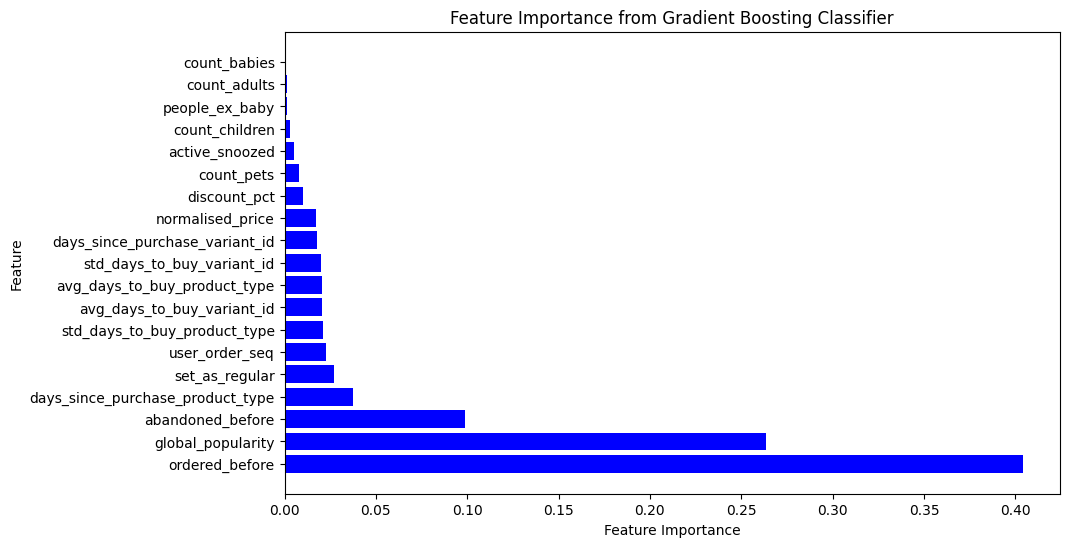

In [26]:
feature_importances = pipeline_gbt.named_steps['gbt_model'].feature_importances_
all_feature_names = np.array(train_cols)


sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = all_feature_names[sorted_idx]

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color='b')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Gradient Boosting Classifier')
plt.show()
import pickle
prefix_path = "models/"
with open(f"{prefix_path}gbt_no_categ.pkl", "wb") as file:
    pickle.dump(gbt_model, file)


Se van a realizar distintas pruebas con estos hiperparámetros como base. Posteriormente se procederá a intentar optimizarlos más adecuadamente

#### Categoricas

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [28]:
gbt_model_categ = GradientBoostingClassifier(loss='log_loss'
                          , learning_rate=0.1
                          , n_estimators=100
                          , max_depth=5)

In [29]:
train_cols_categ = train_cols + categ_cols

categorical_transformer = OneHotEncoder(handle_unknown='ignore', max_categories=20)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categ_cols)
    ], remainder='passthrough'
)
pipeline_categs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', gbt_model_categ)
])

pipeline_categs.fit(X_train[train_cols_categ], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=20),
                                                  ['product_type',
                                                   'vendor'])])),
                ('classifier', GradientBoostingClassifier(max_depth=5))])

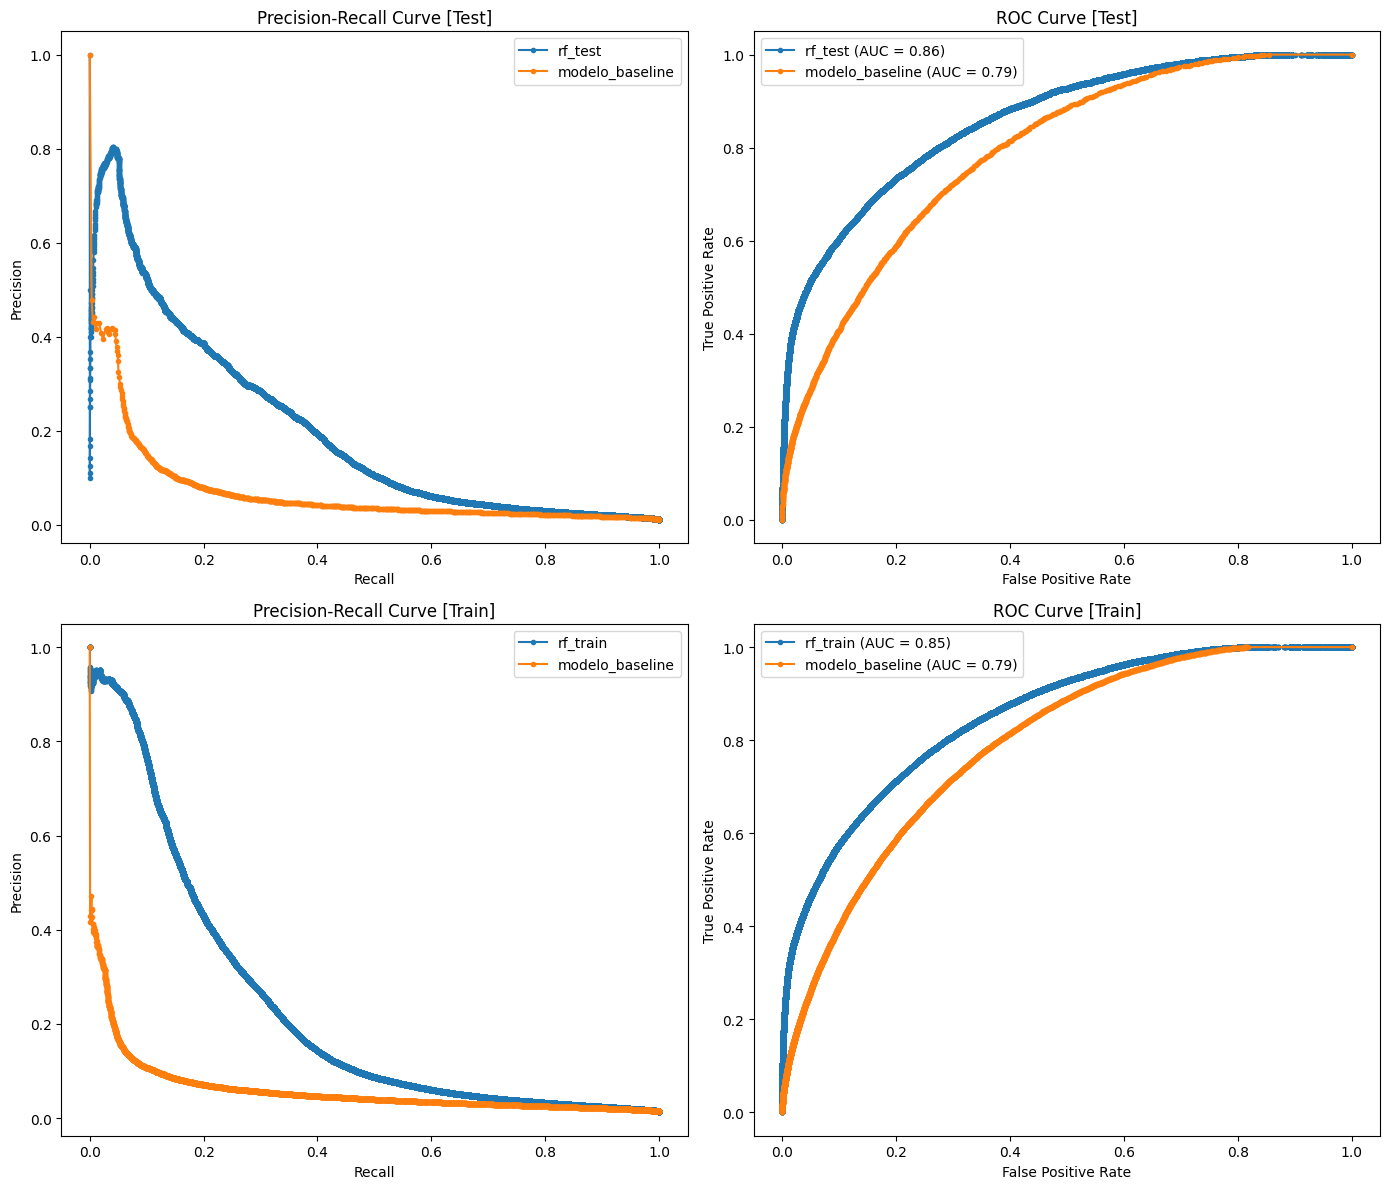

In [30]:
y_pred = pipeline_categs.predict_proba(X_val[train_cols_categ])[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
(ax_test_1, ax_test_2), (ax_train_1, ax_train_2) = axes
generate_metrics(ax_test_1, ax_test_2, y_pred, y_val, label=f'rf_test')
generate_metrics(ax_test_1, ax_test_2, X_val['global_popularity'], y_val, label=f'modelo_baseline')
# Sobre train
y_pred_train = pipeline_categs.predict_proba(X_train[train_cols_categ])[:, 1]
generate_metrics(ax_train_1, ax_train_2, y_pred_train, y_train, label=f'rf_train')
generate_metrics(ax_train_1, ax_train_2, X_train['global_popularity'], y_train, label=f'modelo_baseline')
ax_test_1.set_title('Precision-Recall Curve [Test]')
ax_test_2.set_title('ROC Curve [Test]')
ax_train_1.set_title('Precision-Recall Curve [Train]')
ax_train_2.set_title('ROC Curve [Train]')

plt.tight_layout()
plt.show()

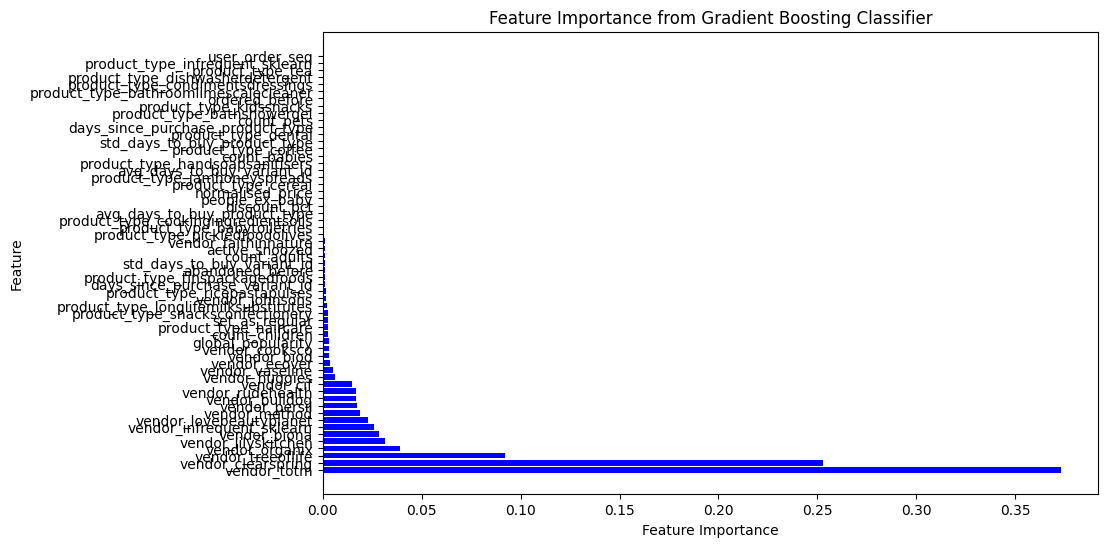

In [31]:
feature_importances = pipeline_categs.named_steps['classifier'].feature_importances_

# Get feature names from the preprocessor
onehot_feature_names = pipeline_categs.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categ_cols)
all_feature_names = np.concatenate([train_cols, onehot_feature_names])

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = all_feature_names[sorted_idx]

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color='b')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Gradient Boosting Classifier')
plt.show()


A mi, personalmente, este modelo me incomoda mucho. Es evidentente que el vendedor influye en la decisión. Pero obtiene unas métricas equivalentes al que solo usa variables numéricas y nos evitamos depender de unas categoricas con cardinalidad alta, donde no se está teniendo control de que categorías están colisionando.

Me quedo con un modelo sin categóricas, que mejora el _baseline_ y el modelo lineal. Eliminamos algunos features y preparamos una optimización de hiperparámetros.

Como actualización posterior, salió justo en clase que _feature importance_ tiende a sobrerrepresentar las variables categóricas de alta cardinalidad, por como se realiza el cálculo. Y esto es un caso de manual de eso.

### Optimización de hiperparámetros

#### Grid Search

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
pipeline_tt = Pipeline(steps=[
    ('classifier', gbt_model)
])

In [34]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7, 9, 11]
}

# # Set up the grid search
# grid_search = GridSearchCV(pipeline_tt, param_grid, cv=2, scoring='roc_auc', n_jobs=1)

# # Perform the grid search
# grid_search.fit(X_train[train_cols], y_train)

# # Get the best model from the grid search
# best_model = grid_search.best_estimator_

Nos quedamos el modelo que mejor estime. Lo he dejado vacío porque tengo problemas o bien con la RAM o bien con algo relativo a CPU que hace que los gridsearch que involucren un número considerable de posiblidades se queden colgados. Lo dejo planteado

### Conclusiones finales.

A través de la utilización de modelos no lineales se consigue un modelo mejorado respecto al lineal, que se vió en el modelo 2.

Se ha descartado la inclusión de variables categóricas, ya que dada su alta cardinalidad, introducen mucho ruido al intentar dar explicabilidad al modelo.

A nivel de opinión personal, no me ha quedado nada sobreajustado en ningún momento, salvon con rf, pero esto no ha ocurrido con gbt, a no ser que le metiera mucha profundidad a los árboles (~13-15) y nunca por número de estimadores. Las diferencias con el lineal, aunque existen, no son notables (AUC de 0.85 contra AUC de 0.81) y en rf el AUC era peor que el lineal.

Me gustaría, que no lo he conseguido del todo, entender porque ocurre todo esto.

¿Cómo puede ser que rf explique el problema peor que una regresión logística?
¿Se puede mejorar mucho el 0.85? Deberían poder conseguirse cosas, pero no llego a ello.

Un saludo!